# Using grid search to find the best model with cross validation

So you have a few different hyper parameters to try?  Like maybe you're trying to use k-NN for something, bu you don't know which k?  Well that's a hyper-parameter... so is C for regularization or which penalty you want to try.  Grid search will try all possible combinations of different hyper parameters you ask it to.  And it will tell you which of those params is the best version in terms of cross-validation performance.

Let's see it in action

In [14]:
import numpy as np

import seaborn as sns

import pandas as pd 

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

# lets get some 🐧 data to work with
df = sns.load_dataset('penguins').dropna()

# what we want to predict
y = df['species']
X = df.drop(columns=['island','species'])

# setup a way to transform the categorical variables into one hot, 
# and to z-score the numeric variables
# remember how we had to do this with a bunch of different
# steps manually the last time around??
# if you'd like to understand how to do this more generally
# search the sklearn docs for ColumnTransformer!
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

onehot = OneHotEncoder()
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('onehot', onehot, categorical_columns),
    ('zscore', scaler, numerical_columns)])


# Create a pipeline 
pipe = Pipeline([('make_features', preprocessor),
                 ('classifier', LogisticRegression(solver='saga', max_iter=10000))])

# Create search space of hyperparameters
# the variable namespace looks like this
# pipe.classifier.C is represented as 'classifier__C'
# if we'd just chucked a LogisticRegression() in as the model
# instead of a pipe, then we'd only have had 'C' w/o the 'classifier__' bit 
search_space = {'classifier__C': np.logspace(-4, 4, 9),
               'classifier__penalty': ['l2', 'l1']}

# Create a grid search object to find the best model
best_model = GridSearchCV(pipe, search_space, cv=5, verbose=3)
# play with different verbose=??

# now lets split off some of our data for testing set... the rest will be used from cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=101)


# Fit grid search
best_model.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END classifier__C=0.0001, classifier__penalty=l2;, score=0.440 total time=   0.0s
[CV 2/5] END classifier__C=0.0001, classifier__penalty=l2;, score=0.440 total time=   0.0s
[CV 3/5] END classifier__C=0.0001, classifier__penalty=l2;, score=0.440 total time=   0.0s
[CV 4/5] END classifier__C=0.0001, classifier__penalty=l2;, score=0.440 total time=   0.0s
[CV 5/5] END classifier__C=0.0001, classifier__penalty=l2;, score=0.449 total time=   0.0s
[CV 1/5] END classifier__C=0.0001, classifier__penalty=l1;, score=0.440 total time=   0.0s
[CV 2/5] END classifier__C=0.0001, classifier__penalty=l1;, score=0.440 total time=   0.0s
[CV 3/5] END classifier__C=0.0001, classifier__penalty=l1;, score=0.380 total time=   0.0s
[CV 4/5] END classifier__C=0.0001, classifier__penalty=l1;, score=0.440 total time=   0.0s
[CV 5/5] END classifier__C=0.0001, classifier__penalty=l1;, score=0.367 total time=   0.0s
[CV 1/5] END classifier__C=0.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('make_features',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['sex']),
                                                                        ('zscore',
                                                                         StandardScaler(),
                                                                         ['bill_length_mm',
                                                                          'bill_depth_mm',
                                                                          'flipper_length_mm',
                                                                          'body_mass_g'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           solver='saga'))]),
             param_grid={'classifier__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'classifier__penalty': ['l2', 'l1']},
             verbose=3)

In [12]:
# hay our best model has these params, and it turns out its cross validation score was perfect!
# note how sklearn does this... once it determines the best version of the classifier
# it refits those parameters on ALL of `X_train`... 
# in other worsds it doesn't just leave the last cross validaiton fold version hanging around :)
best_model.best_params_, best_model.best_score_

({'classifier__C': 10.0, 'classifier__penalty': 'l1'}, 1.0)

If you pick the right `verbose` level for the grid search you will see performance metrics for each parameter checked... but printing is hard to understand sometimes.  You might want to use a graph to explore if there is some kind of systematic change in validation set performance, such that there is a cluster in the search space of relatively good answers? To answer that (at least with 2 hyperparameters... gets tricky with larger numbers) you could do a seaborn heatmap

,C,penalty,accuracy
0,0.0001,l2,0.441796
1,0.0001,l1,0.429796
2,0.0010,l2,0.819265
3,0.0010,l1,0.441796
4,0.0100,l2,0.859429
5,0.0100,l1,0.441796
6,0.1000,l2,0.984000
7,0.1000,l1,0.967918
8,1.0000,l2,0.992000
9,1.0000,l1,0.988000


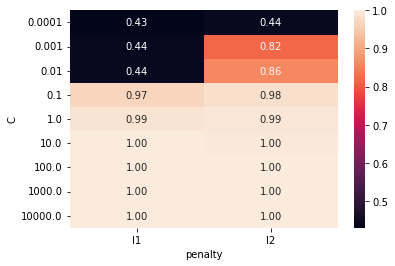

In [8]:
results = pd.DataFrame( best_model.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we could use 1 - x
results['accuracy'] = best_model.cv_results_['mean_test_score']

# get rid of classifier__XX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results across penalty & C values
sns.heatmap( results.pivot('C','penalty','accuracy'),
             annot=True, fmt='3.2f')

results


When there are multiple "best" parameter choices that all yield the same score, then best params (C=10, penalty=l1) are the first ones in the grid list that get the best score.

Now one might reasonably NOT want the first ones in the list... maybe you have a reason to prefer l1 over l2 or maybe you have a reason to prefer stronger regularization (lower C) over weaker regularization (higher C)... or vice versa.  

So don't just blindly accept this as the "best model" when there are often multiple such models with similar or identical scores.

And since I mentioned similar... ask yourself at what point are validation performance levels between two set of parameters so similar that you find them identical?  0.0 difference?  $10^{-6}, 10^{-3}, 10^{-1}$ diffference?  Surely if you prefer stronger regularization there would be a small non-zero difference, where the weaker regularizer did better but you'd actually choose the stronger one instead?

Some additional thoughts for you... what if you want to collect multiple metrics while you are searching.  Its dumb to redo the grid search again... you just wanted a different measurement of the same train/hold-out data on the same model as before.  turns out you can indeed do that, you should check out the docs for GridSearchCV, but the call would be something like 

```python
best_model = GridSearchCV( pipe, search_space, cv=5, 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose = 3 )       
```
in order to collect the three metrics in the scoring list.  You should really read the docs though, as this will change a bit of how the best_model looks after the `fit()` call and might require you to rearrange things to do the heatmap above, etc.

### Now how good is the best model?


Note that the `mean_test_error` we saw above is actually a mislabeling for our purposes... that's validation error!  We've been doing model selection by doing cross-validation and picking the best result that way.

Remember that before we did cross validation we first split off a chunk of the data as a test set. Becauase this data was not used during the grid search it is an independent dataset and provides a less biased estimate of performance than the cross validation estimate.  In other words, it wouldn't be surprising to see that test set performance is somewhat lower than validation set performance used to select the best model!

BTW just a reminder that the `best_model` is fit on all of `X_train` at the end of the grid search. So its ready to predict with the test set

In [15]:
# uses the best_params to predict on the test set
best_model.predict(X_test)

array(['Chinstrap', 'Gentoo', 'Adelie', 'Adelie', 'Chinstrap', 'Gentoo',
       'Adelie', 'Gentoo', 'Chinstrap', 'Adelie', 'Chinstrap', 'Adelie',
       'Adelie', 'Adelie', 'Gentoo', 'Adelie', 'Gentoo', 'Adelie',
       'Gentoo', 'Adelie', 'Gentoo', 'Gentoo', 'Adelie', 'Gentoo',
       'Adelie', 'Adelie', 'Chinstrap', 'Chinstrap', 'Adelie', 'Adelie',
       'Gentoo', 'Adelie', 'Chinstrap', 'Adelie', 'Adelie', 'Chinstrap',
       'Adelie', 'Adelie', 'Chinstrap', 'Gentoo', 'Adelie', 'Gentoo',
       'Gentoo', 'Adelie', 'Adelie', 'Chinstrap', 'Adelie', 'Gentoo',
       'Chinstrap', 'Chinstrap', 'Gentoo', 'Adelie', 'Chinstrap',
       'Gentoo', 'Adelie', 'Adelie', 'Adelie', 'Gentoo', 'Chinstrap',
       'Gentoo', 'Adelie', 'Gentoo', 'Chinstrap', 'Adelie', 'Adelie',
       'Gentoo', 'Chinstrap', 'Gentoo', 'Gentoo', 'Chinstrap', 'Adelie',
       'Gentoo', 'Chinstrap', 'Chinstrap', 'Chinstrap', 'Gentoo',
       'Gentoo', 'Adelie', 'Chinstrap', 'Adelie', 'Adelie', 'Chinstrap',
       'Adelie',

In [16]:
# lets find out how well we do on the test set... turns out not quite as well as on validation!
# that is in fact expected, because there is a kind of information leakage here between train and hold out scores
# think about how that might be true :)
best_model.score(X_test, y_test)

0.9880952380952381

## Nested cross validation

Now k-fold cross-validation by itself is a good-enough method of model selection. It is pretty efficient at using the data, so it can handle small-ish data tasks. It is pretty unbiased, especially when you use k around 5 or 10 for datasets with several hundred samples. 

But there are several important refinements we may need to make, depedending on the situation.

Note that we had to split off a test set before cross-validation above... that's data we couldn't use during model selction!  Instead what if every single data point could take its turn as training data, validation data, and test data?  That's nested cross-val.

Varma and Simon found that the nested cross-validation approach can reduce the bias, compared to regular k-fold cross-validation when used for both hyperparameter tuning and evaluation:  "A nested CV procedure provides an almost unbiased estimate of the true error" (Varma and Simon, *BMC bioinformatics*, 7(1):91, 2006).


The method of nested cross-validation is relatively straight-forward as it merely is a nesting of two k-fold cross-validation loops: the inner loop is responsible for the model selection, and the outer loop is responsible for estimating the generalization accuracy, as shown below. 



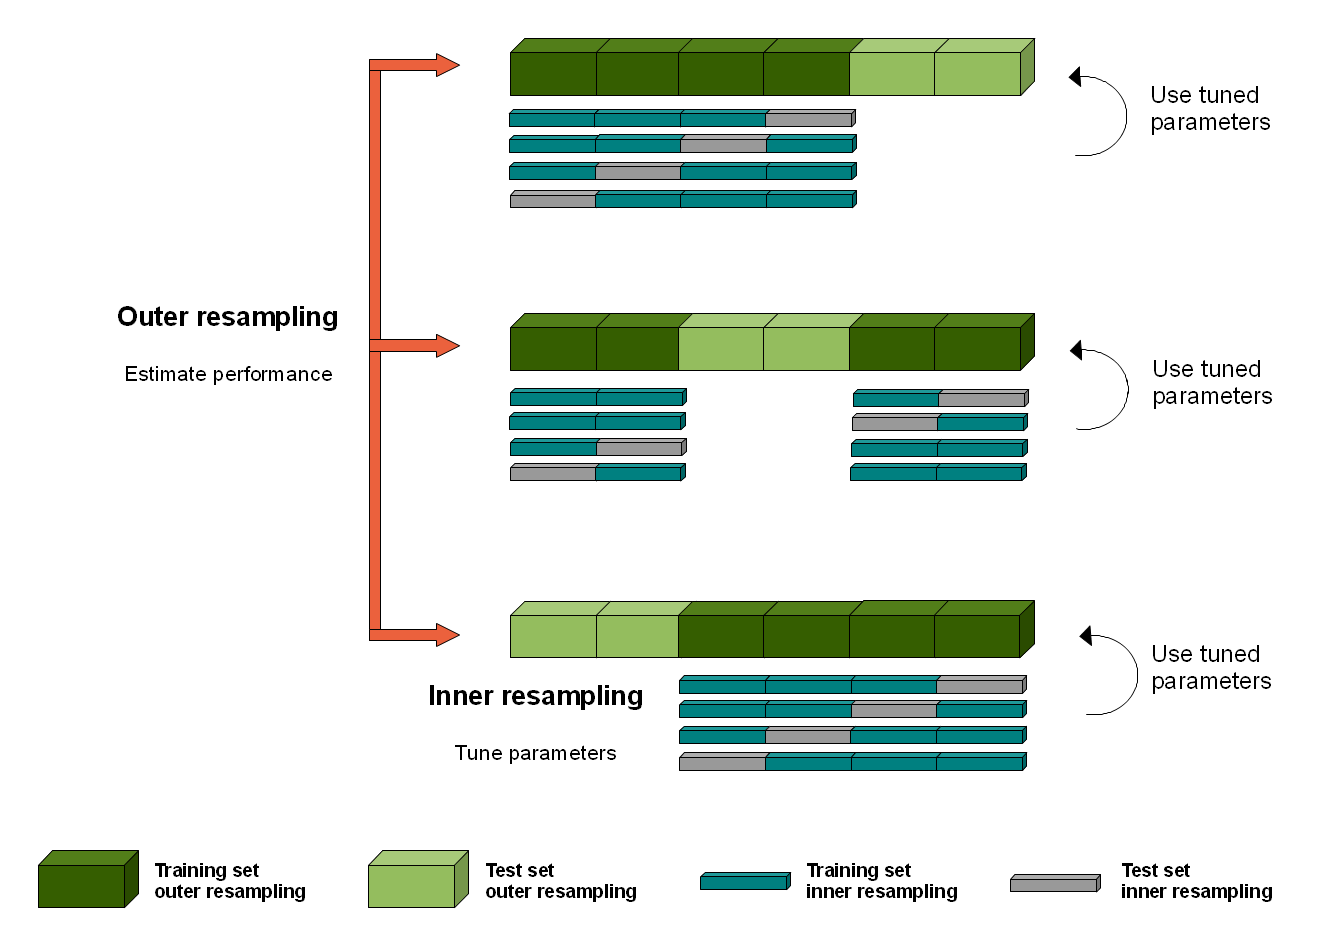



### Implementation in sklearn to match the figure above

```python
inner_cv = KFold(n_splits=4)
outer_cv = KFold(n_splits=6)

inner_search = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv)
outer_search = GridSearchCV(estimator=inner_search, param_grid=p_grid, cv=outer_cv)

outer_search.fit(X,y)
```

### More thoughts
NB: This is one of MANY methods for trying to squeeze every drop of information out of small sample data and produce optimal estimates of generalization for model selection. As I said above plain old X-val is often "good enough". 

If you'd like to see a nice discussion of other methods for optimizing model selection, take a look at https://arxiv.org/abs/1811.12808 which are lecture notes for a class similar to this one that goes more in depth on this matter.


In the meantime, let's see just how much better nested is than regular x-val at this dataset

Average difference of 0.003153 with std. dev. of 0.002222.


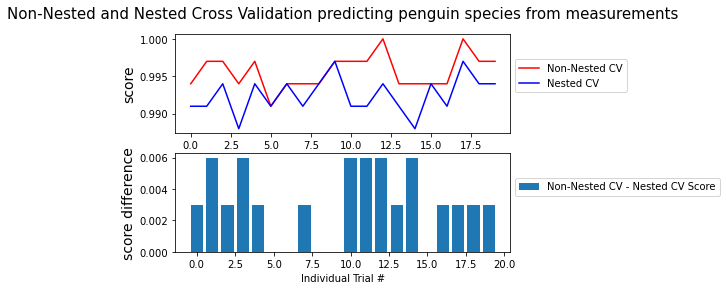

CPU times: user 25.7 s, sys: 62.7 ms, total: 25.8 s
Wall time: 25.7 s


In [24]:
# this code is from sklearn docs
# 20x it does both a non-nested and a nested cross val on the same data
# the two techniques are compared in their average error across the 20x loop

%%time 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt

# Number of random trials
NUM_TRIALS = 20


# Set up possible values of parameters to optimize over
# this is a regularization parameter, smaller C => more regularization
p_grid = {"classifier__C": [1, 10, 100,  1000]}


# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=pipe, param_grid=p_grid, cv=inner_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(1, 0, 0, .8)) #(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation predicting penguin species from measurements",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(1, 0, 0, .8))
plt.ylabel("score difference", fontsize="14")

plt.show()


So yeah, turns out the regular old cross-val is both over estimating how good the best model will be, and also doing so with more variability.  In fact the average overesimate by non-nested cross val is very close the overestimate we saw when comparing cross val score vs test set score in the first section of this notebook  

---
Acknowledgements: This notebook is a hodgepodge of my work plus stuff from open source notebooks in sklearn documentation, and also by Jake Van Der Plas, Sebastian Rashkha, and Chris Albon. If you don't pay attention to these people on the interwebs you should.
